# Preparación de datos – Clasificación de nivel de gasto

## 1) Objetivo
Preparar los datos para entrenar un modelo de Machine Learning que clasifique
a los clientes según su nivel de gasto (bajo, medio o alto), con el fin de
apoyar estrategias de segmentación y marketing.

## 2) Importación de librerías

In [ ]:
import pandas as pd
import numpy as np


## 3) Carga de datos

Se carga el dataset de transacciones de compras en retail.

In [70]:
df = pd.read_csv('../data/raw/customer_shopping_data.csv')
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


## 4) Exploración inicial del dataset

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [72]:
df.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


## 5) Limpieza de datos

Se eliminan registros incompletos y se validan variables clave
para garantizar la calidad del dataset.

In [73]:
# Verificar valores nulos
df.isnull().sum()

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64

In [74]:
# Eliminar duplicados
df = df.drop_duplicates()
df.shape

(99457, 10)

## 6) Cálculo del gasto por transacción

In [75]:
df['Gasto_Total'] = df['quantity'] * df['price']
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Gasto_Total
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon,242.40


## 7) Variable objetivo

### Definición del nivel de gasto

Se clasifica el gasto del cliente en tres niveles usando percentiles:
- Bajo: hasta el percentil 33
- Medio: percentil 33 a 66
- Alto: mayor al percentil 66

In [76]:
p33 = df['Gasto_Total'].quantile(0.33)
p66 = df['Gasto_Total'].quantile(0.66)

def clasificar_gasto(gasto):
    if gasto <= p33:
        return 'Bajo'
    elif gasto <= p66:
        return 'Medio'
    else:
        return 'Alto'

df['Nivel_Gasto'] = df['Gasto_Total'].apply(clasificar_gasto)
df['Nivel_Gasto'].value_counts()

Nivel_Gasto
Bajo     33645
Medio    33015
Alto     32797
Name: count, dtype: int64

## 8) Variables predictoras

Se utilizan variables disponibles antes o durante la compra,
evitando información que cause fuga de datos.

In [77]:
features = df[[
    'age',
    'gender',
    'category',
    'payment_method',
    'shopping_mall'
]]

target = df['Nivel_Gasto']

## 9) Renombrar columnas

In [78]:
features = features.rename(columns={
    'age': 'Edad',
    'gender': 'Genero',
    'category': 'Categoria_Producto',
    'payment_method': 'Metodo_Pago',
    'shopping_mall': 'Shopping_Mall'
})

target.name = 'Nivel_Gasto'

## 10) Dataset final para Machine Learning

Se seleccionan las variables que serán utilizadas como entrada del modelo y la validad objetivo

In [79]:
dataset_ml = pd.concat([features, target], axis=1)
dataset_ml.head()

,Edad,Genero,Categoria_Producto,Metodo_Pago,Shopping_Mall,Nivel_Gasto
0,28,Female,Clothing,Credit Card,Kanyon,Alto
1,21,Male,Shoes,Debit Card,Forum Istanbul,Alto
2,20,Male,Clothing,Cash,Metrocity,Medio
3,66,Female,Shoes,Credit Card,Metropol AVM,Alto
4,53,Female,Books,Cash,Kanyon,Bajo


## 11) Análisis del gasto del cliente

In [81]:
dataset_ml['Nivel_Gasto'].describe()

count     99457
unique        3
top        Bajo
freq      33645
Name: Nivel_Gasto, dtype: object

<Axes: >

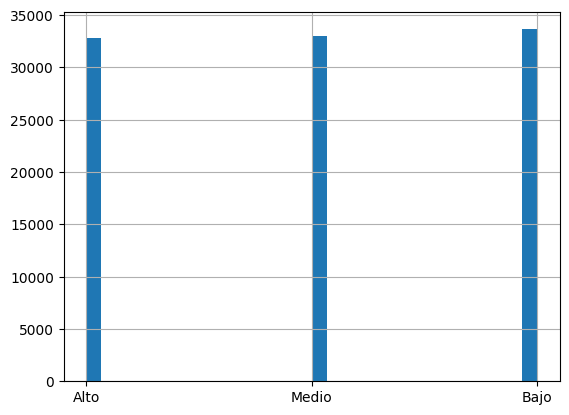

In [83]:
dataset_ml['Nivel_Gasto'].hist(bins=30)

## 12) Exportación del dataset procesado

In [85]:
dataset_ml.to_csv('../data/processed/clientes_clasificacion.csv', index=False)

## 13) Conclusiones

Se construyó un dataset orientado a clasificación que permite segmentar
clientes por nivel de gasto sin incurrir en fuga de información,
asegurando validez del modelo y utilidad de negocio.